# Read and plot nc data

In [3]:
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import codecs
import pandas as pd
import matplotlib.colors
import xarray as xr
import math
from datetime import datetime

In [4]:
# fig, ax= plt.subplots(1,2, figsize=(18, 6))

def read_data(path_atom_meta):
    ds_atom_palms = xr.open_mfdataset(path_atom_meta,
                              group='PALMS-PartType-Mass', 
                              concat_dim = 'time', 
                              combine = 'nested', 
                              preprocess=lambda ds: 
                              ds[['SeaSaltMass_PALMS','BioBurnMass_PALMS','OilCombMass_PALMS']])
    
    
    
    ds_atom_meta = xr.open_mfdataset(path_atom_meta,
                                     group='AMS', 
                                     concat_dim = 'time', 
                                     combine = 'nested', 
                                     preprocess=lambda ds: 
                                     ds[['ALT_AMS', 'LON_AMS', 'LAT_AMS','OA_PM1_AMS']])
    
    ds_atom_meta_p = xr.open_mfdataset(path_atom_meta,
                                     group='MMS', 
                                     concat_dim = 'time', 
                                     combine = 'nested', 
                                     preprocess=lambda ds: 
                                     ds[['P']]) 

    ds_atom_time = xr.open_mfdataset(path_atom_meta, 
                                     concat_dim = 'time', 
                                     combine = 'nested',
                                     preprocess=lambda ds: ds[['time']])
    
    return ds_atom_palms,ds_atom_meta,ds_atom_time,ds_atom_meta_p

In [5]:
colors = ['r','b','g','m']
names = ['ATom-1','ATom-2','ATom-3','ATom-4']
dates = []
altitude = []
oa_mass= []
for i in range(4):
    var_list_atom = ['N_accum_AMP']
    path_atom_meta = f'/Users/leon/Desktop/MODEL_eval/ATom/ATom-merge_ncfiles/MER-SAGA*{i+1}.nc'
    ds_atom_c,ds_atom_meta,ds_atom_time,_ = read_data(path_atom_meta)

    dates.append([datetime.strptime(str(m),'%Y-%m-%dT%H:%M:%S.000000000') for m in ds_atom_time['time'].values])
    altitude.append(ds_atom_meta['ALT_AMS'].values/1000)
    oa_mass.append(ds_atom_meta['OA_PM1_AMS'].values)
    
    


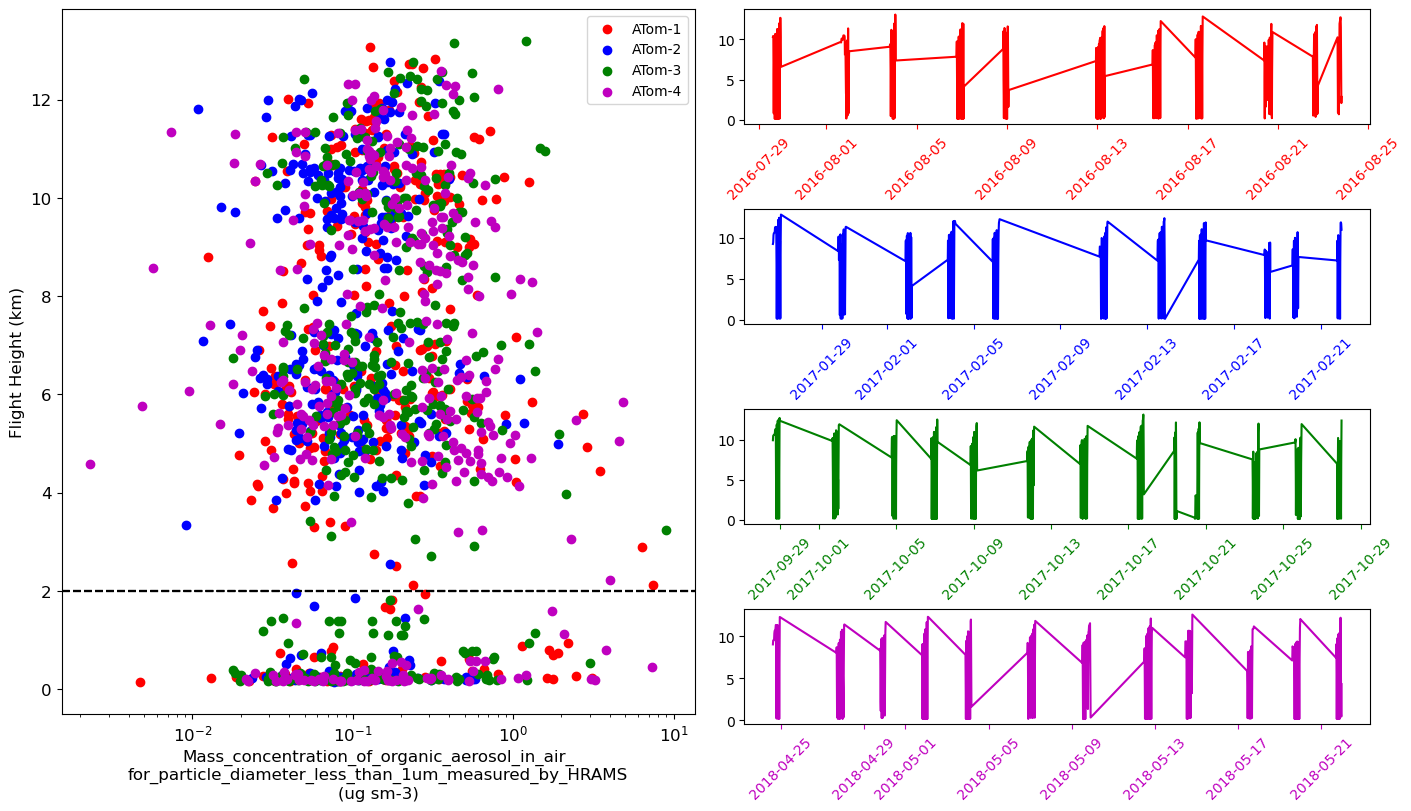

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(14, 8))
(subfig1,subfig2) = fig.subfigures(nrows = 1, ncols = 2)
subfigs = [subfig1,subfig2]
ax = subfig1.subplots(nrows=1, ncols=1)
for i,axs in enumerate(colors):
    ax.scatter(oa_mass[i],altitude[i],c = colors[i],label=names[i])
    ax.tick_params(axis = 'both',labelsize = '12')
    ax.axhline(y = 2, color = 'k', linestyle = '--') 

ax.set_ylabel('Flight Height (km)',fontsize = 12)
ax.set_xlabel('Mass_concentration_of_organic_aerosol_in_air_\n'
                 'for_particle_diameter_less_than_1um_measured_by_HRAMS\n(ug sm-3)'
             ,fontsize = 12)
ax.set_xscale('log')


axes = subfig2.subplots(nrows=4, ncols=1)
# axes.flatten()
for i,axs in enumerate(axes):
    axs.plot(dates[i],altitude[i],c = colors[i])
    axs.tick_params(axis='x', labelrotation=45,colors = colors[i])  
    axs.yaxis.label.set_color(colors[i])
    axs.tick_params(axis = 'both',labelsize = '10')

ax.legend()
plt.savefig('mass_conc_OA_flight_height.png',dpi = 300)

In [7]:
#Reading all files
base_path = f'/Users/leon/Desktop/MODEL_eval/ATom/ATom-merge_ncfiles/MER-SAGA'

path_atom_meta = f'{base_path}*.nc'
ds_atom_c,ds_atom_meta,ds_atom_time,ds_atom_meta_p = read_data(path_atom_meta)


In [8]:
def find_region(var_set,cond,dicc,sub_na):
    variables = []
    for i,v in enumerate(var_set):
        if len(cond) <= 1:
            v = v.where((cond[0][0]>cond[0][1]) &
                        (cond[0][0]<cond[0][2])
                        ,drop=True)
        elif len(cond) > 1:
            v = v.where(((cond[0][0]>cond[0][1]) & 
                     (cond[0][0]<cond[0][2]) &
                     (cond[1][0]>cond[1][1]) & 
                     (cond[1][0]<cond[1][2]))
                     ,drop=True)
        
        variables.append(v)
        dicc[sub_na[i]] = v
    return dicc,variables


In [9]:
ds_atom_time['time'][:6]

<xarray.DataArray 'time' (time: 6)>
array(['2016-07-29T15:08:30.000000000', '2016-07-29T15:23:30.000000000',
       '2016-07-29T15:35:30.000000000', '2016-07-29T15:50:00.000000000',
       '2016-07-29T16:01:30.000000000', '2016-07-29T16:14:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-07-29T15:08:30 ... 2016-07-29T16:14:00
Attributes:
    standard_name:  time
    bounds:         time_bnds

In [10]:
ds_atom_c['P'] = ds_atom_meta_p['P']*100

ds_atom = ds_atom_c.assign(lat=ds_atom_meta['LAT_AMS'], 
                           lon=ds_atom_meta['LON_AMS']%360, 
                           alt=ds_atom_meta['ALT_AMS'],
                           OA_PM1_AMS=ds_atom_meta['OA_PM1_AMS'],
                           time=ds_atom_time['time'])


# selecting only atom levels under 1 km height
ds_atom=ds_atom.where(ds_atom['alt'].compute()<1000,drop = 'True')
ds_atom=ds_atom.where((ds_atom['OA_PM1_AMS'].compute()>0.)&(ds_atom['OA_PM1_AMS'].compute()<0.2),drop = 'True')


In [11]:


lat = ds_atom['lat'].compute()
lon = ds_atom['lon'].compute()
data = ds_atom['SeaSaltMass_PALMS'].compute()
alt = ds_atom['alt'].compute()
pres = ds_atom['P'].compute()
date = ds_atom['time'].compute()


# reg_data = {'N. Pole': [],
#             'S. Pole': [],
#             'S. Pacific': [],
#             'N. Pacific': [],
#             'S. Atlantic': [],
#             'N. Atlantic': [],
#             'Sub. Pacific': [],
#             'Sub. Atlantic': [], }

reg_data = {'S. Atlantic':[],
            'S. Pacific':[],
            'C. Pacific':[],
            'N. Pacific': [],
            'N. Atlantic':[],
            'N. Pole': [],
           
           }

subkeys = {'latitud': [],
           'longitud': [],
           'aer_data': [],
           'model_data': [],
           'altitude': [],
           'pressure': [],
           'time': []}

# def get_cond_list(lat,lon):
    # conditions = [[[lat, 55, 90]],
    #               [[lat, -80, -55]],
    #               [[lat, -55, -23], [lon, 130, 290]],
    #               [[lat, 23, 55], [lon, 130, 240]],
    #               [[lat, -55, -23], [lon, 290, 360]],
    #               [[lat, 23, 55], [lon, 300, 360]],
    #               [[lat, -23, 23], [lon, 130, 290]],
    #               [[lat, -23, 23], [lon, 300, 360]]]
conditions = [[[lat, -90, 0], [lon, 290, 360]],
              [[lat, -90, -23], [lon, 130, 290]],
              [[lat, -23, 23], [lon, 130, 290]],
              [[lat, 23, 63], [lon, 130, 240]],
              [[lat, 0, 63], [lon, 300, 360]],
              [[lat, 63, 90]],
             ]
#     return conditions
for na in reg_data.keys():
    reg_data[na]={'latitud':[],
                 'longitud':[],
                 'aer_data':[],
                 'model_data':[],
                 'altitude': [],
                 'pressure': [],
                 'time':[]}
    

color_reg = ['y','r','lightgreen','g','m','k','b','orange']

for i,na in enumerate(reg_data.keys()):
    sub_na = list(reg_data[na].keys())
    variables = [lat,lon,data,alt,pres,date]
    reg_data[na],_ = find_region(variables,
                               conditions[i],
                               reg_data[na],
                               sub_na)

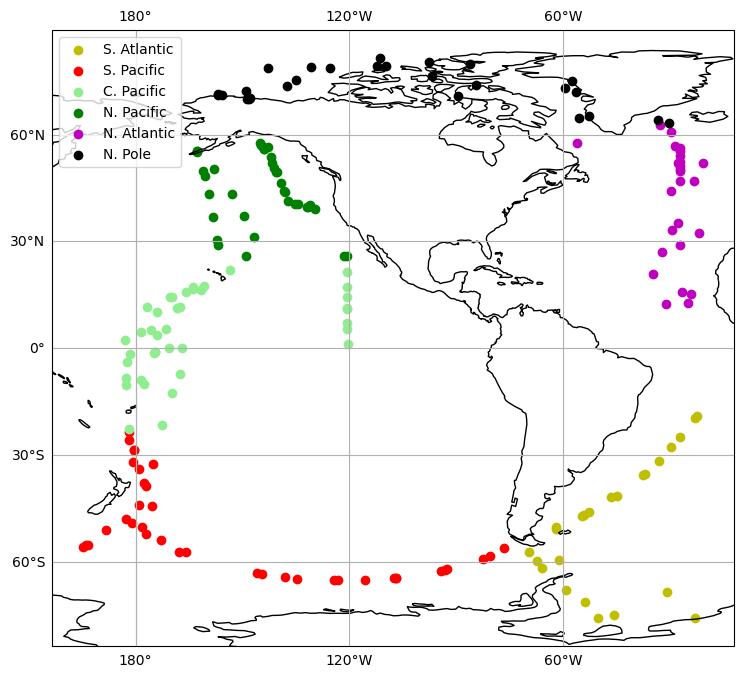

In [11]:
fig,ax = plt.subplots(1,1,figsize=(9, 8),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},)
for i,na in enumerate(reg_data.keys()):
    cb = ax.scatter(reg_data[na]['longitud'],reg_data[na]['latitud'], c =color_reg[i], label=na,
                    transform = ccrs.PlateCarree())
    
ax.legend(loc='upper left')
ax.coastlines()
ax.gridlines(draw_labels=True,)
plt.savefig('atom_region_sel.png',dpi = 300)

### Products to generate
#### - Mass concentration of SS and OA for the BL (300 m max) .vs. model surface level (plots from Swetlana)
#### - Mass concentration of OA .vs. model interpolated vertical values. 
#### - Particle number concentration ??
#### - Calculate statistics (correlation, atom .vs. model). 
#### - Split it into 2 groups (like the fig above, y > 2 km and y < 2 km) and analyze correlation at the lowest most model level and interpolated levels with respect to high altitudes
#### - Perform this analysis for all the data and for the regions shown in the map 

In [11]:
np.arange(0.05,0.55,0.05)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [12]:
np.arange(0.02,0.22,0.02)

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

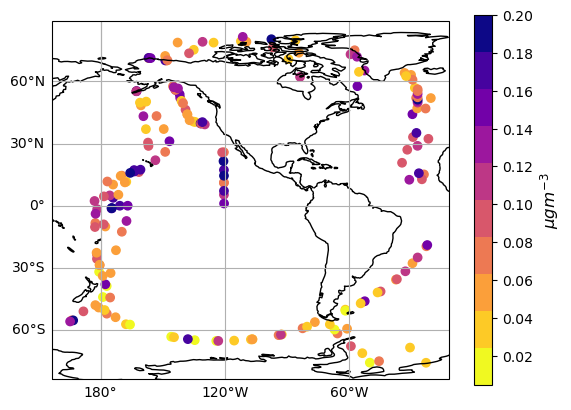

In [13]:
# Calculating difference between model and observations and plotting map results
units = 'ug/m3'

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
cmap = plt.get_cmap('plasma_r', 10)    # 11 discrete colors

map_plot = ax.scatter(ds_atom.lon, 
                      ds_atom.lat, 
                      c=ds_atom['OA_PM1_AMS'].values, 
                      cmap=cmap, #PuBuGn
                      vmax = 0.2,
                      transform=ccrs.PlateCarree())
ax.coastlines()
cbar = fig.colorbar(map_plot, ticks=np.arange(0.02,0.22,0.02))
cbar.set_label(label="${\mu}gm^{-3}$", size='large', weight='bold')
# cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
# cbar.ax.set_yticklabels(np.arange(0,0.5,0.05)) 
# ax.set_title('A')

# add grid lines
gl = ax.gridlines(draw_labels=True, 
                  x_inline=False, 
                  y_inline=False) #adding grid lines with labels
gl.top_labels = False
gl.right_labels = False
plt.savefig(f'Mass_conc_OA.png', bbox_inches='tight')


In [134]:
def get_duplic_month(ds_atom):
    list_number = []
    list_duplic = []
    init_date = []

    m_init = ds_atom['time'].dt.month.values[0]
    n = 0
    n_id = 1
    for i, m in enumerate(ds_atom['time'].dt.month.values):
        if m == m_init:
            n+=1
            list_duplic.append(n_id)
        else:
            list_number.append(n)
            if ds_atom['time'][i].dt.month.values > 9:
                mon = str(ds_atom['time'][i].dt.month.values)
            else:
                mon = '0'+str(ds_atom['time'][i].dt.month.values)       
            date = str(ds_atom['time'][i].dt.year.values)+'-'+ mon
            init_date.append(date)
            n = 1
            n_id +=1
            list_duplic.append(n_id)


        m_init = m
    list_number.append(n)
    
    print(list_number)
    return list_duplic, init_date

6


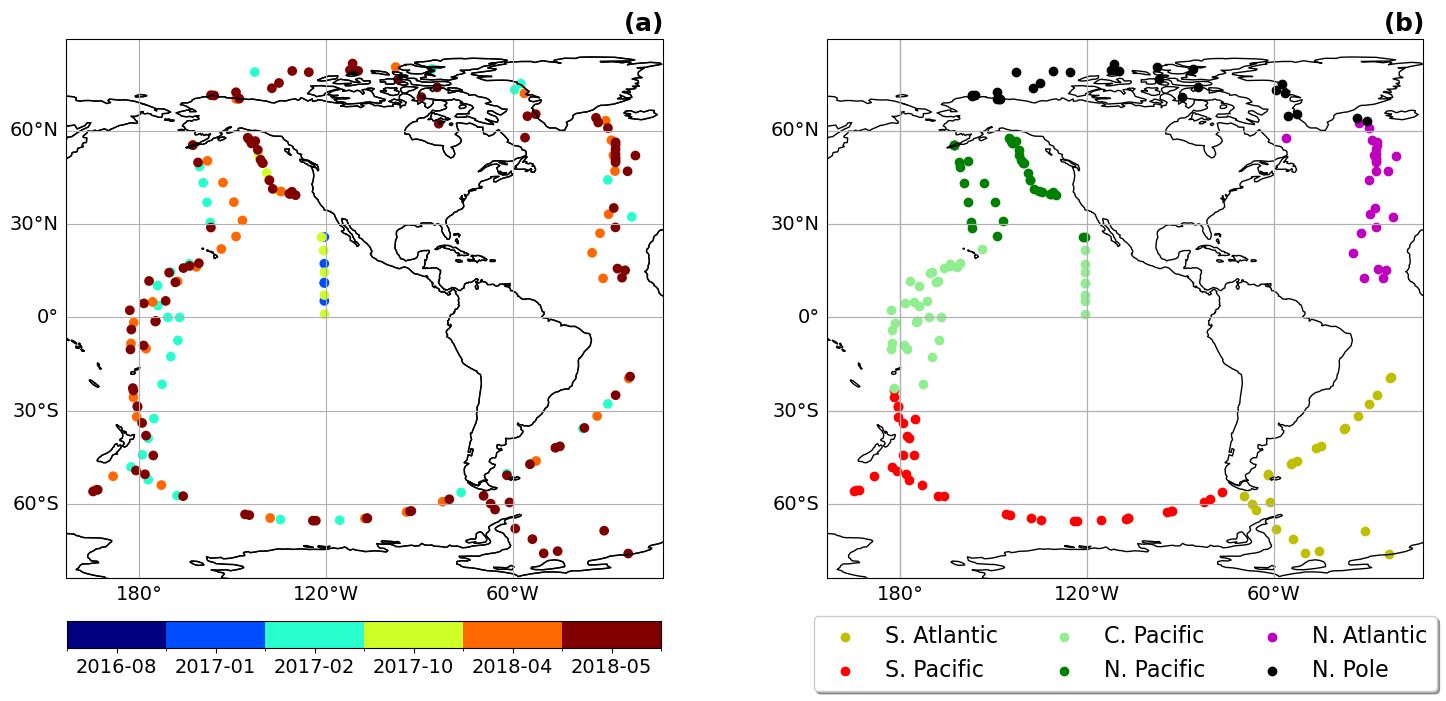

In [133]:
# Calculating difference between model and observations and plotting map results
units = 'ug/m3'

fig,axs = plt.subplots(nrows=1, ncols=2,figsize=(18, 7),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax = axs.flatten()


cb = []
for i,na in enumerate(reg_data.keys()):
    cb.append(ax[1].scatter(reg_data[na]['longitud'],reg_data[na]['latitud'], c =color_reg[i], label=na,
                    transform = ccrs.PlateCarree()))
# ax[0].set_extent([150, 10, -90, 90], crs=ccrs.PlateCarree())

# ax[0].legend(handles = cb, loc='center')
ax[1].coastlines()
ax[1].gridlines()
ax[1].set_title(r'$\bf{(b)}$',loc = 'right',fontsize=18)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, fontsize = 16)


cmap = plt.get_cmap('plasma_r', 10)    # 11 discrete colors
# map_plot = ax[0].scatter(ds_atom.lon, 
#                       ds_atom.lat, 
#                       c=ds_atom['OA_PM1_AMS'].values, 
#                       cmap=cmap, #PuBuGnplasma_r
#                       vmax = 0.2,
#                       transform=ccrs.PlateCarree())
# cax = fig.add_axes([ax[0].get_position().x1+0.03,ax[0].get_position().y0,0.02,ax[0].get_position().height])
# cbar = fig.colorbar(cb, ticks=np.arange(0,n),cax = cax, orientation = 'vertical')
# ax[0].coastlines()
# # plt.colorbar(im,fraction=0.046, pad=0.04)(0.05,0.55,0.05)
# cbar = plt.colorbar(map_plot, ticks=np.arange(0.02,0.22,0.02),fraction=0.06, pad=0.07,location ='bottom')
# cbar.set_label(label="${\mu}gm^{-3}$", size=16, weight='bold')
# cbar.ax.tick_params(labelsize=15)


da_count_month, init_date = get_duplic_month(ds_atom)
n = len(init_date)
print(n)
cmap = plt.get_cmap("jet", n)
norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)

cb = ax[0].scatter(ds_atom.lon, 
                ds_atom.lat, 
                c=da_count_month,cmap=cmap,norm=norm,
                transform = ccrs.PlateCarree())
cax = fig.add_axes([0.136, ax[0].get_position().y0-0.1, 0.33, 0.038])
cbar = fig.colorbar(cb, ticks=np.arange(0,n),cax = cax, orientation = 'horizontal')
cbar.set_ticklabels(init_date, fontsize=14) # set ticks of your format

ax[0].coastlines()
# # plt.colorbar(im,fraction=0.046, pad=0.04)(0.05,0.55,0.05)
# cbar = plt.colorbar(map_plot, ticks=np.arange(0.02,0.22,0.02),fraction=0.06, pad=0.07,location ='bottom')

# ax[0].coastlines()
# # plt.colorbar(im,fraction=0.046, pad=0.04)(0.05,0.55,0.05)
# cbar = plt.colorbar(map_plot, ticks=np.arange(0.02,0.22,0.02),fraction=0.06, pad=0.07,location ='bottom')
# cbar.set_label(label="${\mu}gm^{-3}$", size=16, weight='bold')
# cbar.ax.tick_params(labelsize=15)
# ax[0].set_title(r'$\bf{(a)}$',loc = 'right', fontsize=18)


# add grid lines
for axs in ax:
    gl = axs.gridlines(draw_labels=True, 
                      x_inline=False, 
                      y_inline=False) #adding grid lines with labels
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

plt.savefig(f'Mass_conc_OA_and_regions.png', bbox_inches='tight')

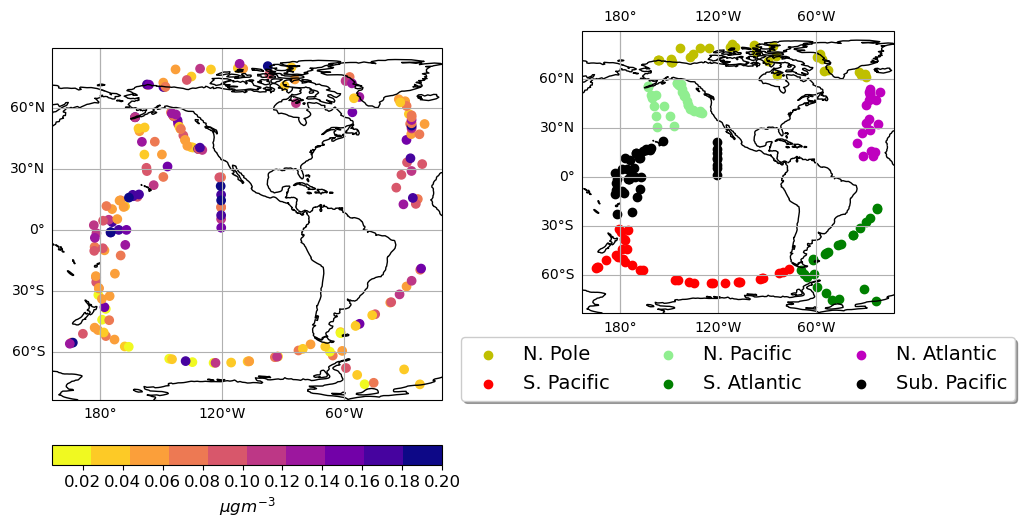

In [57]:
fig = plt.figure(constrained_layout=True,figsize = (10,7))

(subfig1,subfig2) = fig.subfigures(nrows = 1, ncols = 2, wspace=0.01, width_ratios=[1.2, 1.4])

ax1 = subfig1.subplots(nrows=1, ncols=1, sharex=True,
                     subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
cmap = plt.get_cmap('plasma_r', 10)    # 11 discrete colors
map_plot = ax1.scatter(ds_atom.lon, 
                      ds_atom.lat, 
                      c=ds_atom['OA_PM1_AMS'].values, 
                      cmap=cmap, #PuBuGn
                      vmax = 0.2,
                      transform=ccrs.PlateCarree())
ax1.coastlines()
cbar = subfig1.colorbar(map_plot, ticks=np.arange(0.02,0.22,0.02),location='bottom', fraction=0.043, pad=0.04)
cbar.set_label(label="${\mu}gm^{-3}$", size='large', weight='bold')
cbar.ax.tick_params(labelsize=12)

# add grid lines
gl = ax1.gridlines(draw_labels=True, 
                  x_inline=False, 
                  y_inline=False) #adding grid lines with labels
gl.top_labels = False
gl.right_labels = False


ax2 = subfig2.subplots(nrows=1, ncols=1, sharex=True,
                     subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
for i,na in enumerate(reg_data.keys()):
    cb = ax2.scatter(reg_data[na]['longitud'],reg_data[na]['latitud'], c =color_reg[i], label=na,
                    transform = ccrs.PlateCarree())

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, fontsize = 14)
# ax2.legend(loc='upper left')
ax2.coastlines()
ax2.gridlines(draw_labels=True,)



